# __SPARK ASSIGNMENT 1__
> Name : Ilias Dimos <br />
> AM : f2822102 <br />
> Course : Big Data Systems <br />
> Email : f2822102@aueb.gr <br /> 

## __TASK 3__
#### As a final task, your supervisor assigned to you to investigate if it is possible to train a linear regression model (using LinearRegression() function) that could predict the “average_rating” of a book, using as input, its “language_code”, its “num_pages”, its “ratings_count”, and its “publication year”. Again you should use Python and Dataframes, this time with MLlib. You should pay attention to transform the string-based input features (“language_code” and “publication_year”) using the proper representation format, and you should explain your choices. Your code should :

#### __Dataset import.__ 
* In this task its very important to define from the first step the type of our data because Linear Regression works only for numeric data. In the `schema` variable we save the 5 columns we need from the initial dataset.We import the `num_pages` and the `ratings_count` as numeric , the `language_code` and the `publication_year` as strings and the `average_rating` as decimal we 2 digits.
* Because of the missing values , the dataset has , in the string columns , we need to replace them with the word unknown defining that we dont have any kind of information about their values.

In [100]:
from pyspark.sql import SparkSession
#Builing the Spark session with name "Assignment_1_TASK_3
spark = SparkSession.builder.appName("Assignment_1_TASK_3").getOrCreate()

schema = """
`num_pages` numeric,
`ratings_count` numeric,
`language_code` string,
`publication_year` string,
`average_rating` decimal(10,2)

"""
#Importing the "books_5000.json" file with the read.json() command.
dataset_3 = spark.read.json("books_5000.json",schema=schema)
dataset_3 = dataset_3.na.replace('', 'unknown', 'language_code')
dataset_3 = dataset_3.na.replace('', 'unknown', 'publication_year')
dataset_3.printSchema()
dataset_3.show(10)


root
 |-- num_pages: decimal(10,0) (nullable = true)
 |-- ratings_count: decimal(10,0) (nullable = true)
 |-- language_code: string (nullable = true)
 |-- publication_year: string (nullable = true)
 |-- average_rating: decimal(10,2) (nullable = true)

+---------+-------------+-------------+----------------+--------------+
|num_pages|ratings_count|language_code|publication_year|average_rating|
+---------+-------------+-------------+----------------+--------------+
|     null|            1|      unknown|         unknown|          4.12|
|     null|           16|          fre|            2016|          3.94|
|      146|           51|          eng|            2012|          4.28|
|     null|            6|          eng|         unknown|          4.05|
|      272|           51|        en-US|            1997|          4.06|
|      206|           46|      unknown|            2007|          3.44|
|      224|           39|          eng|            2016|          4.15|
|      160|           38|   

#### __Dealing with the `null` values by identifing the outliers in `num_pages` column.__
* Now its time to deal with the `null` values in the column `num_pages`. Deleting the rows where the `num_pages` is `null` is a wrong approach to our problem as we lose valuable information.
* In order to choose how we are going to fill the null values we need to see the distribution of the `num_pages`. Firstly, we extract the specific column from the initial dataset `(dataset_3)`. Secondly with the use of the `Pandas` library we imported the column as dataframe. With the help of the `seaborn` library for visualizations we were able to visualize the outliers of the `num_pages` column.
* The figure `Distribution of Book Pages` shows that we have a lot of outliers in the specific column.

Text(0.5, 1.0, 'Distribution of Book Pages ')

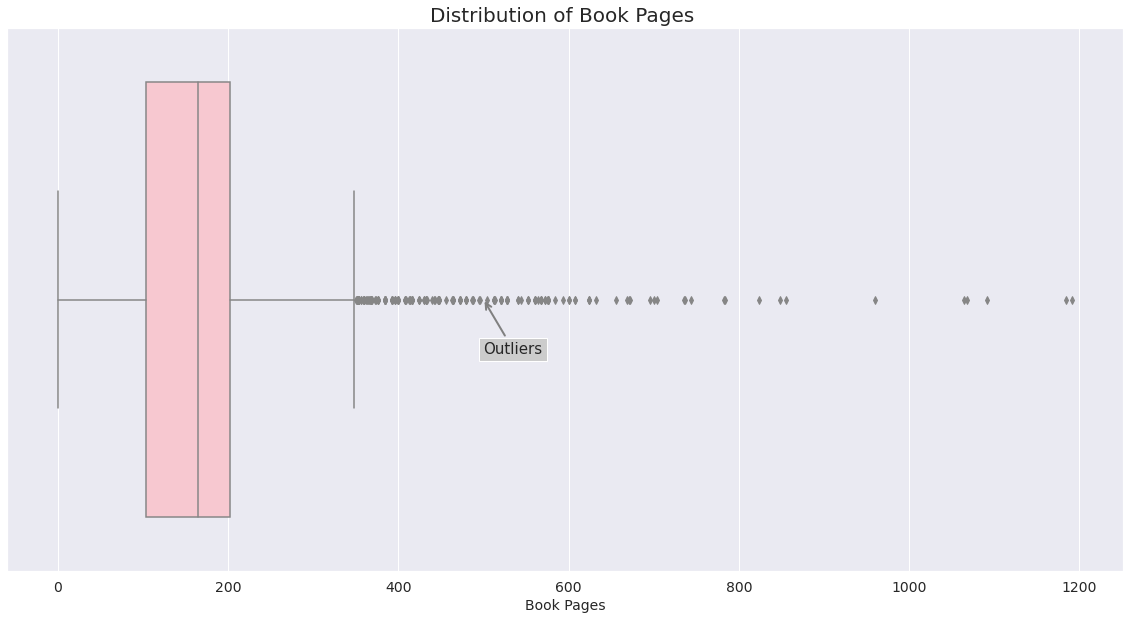

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Dataset importing into a pandas dataframe and saved as "num".
original_numerical_df = dataset_3.select("num_pages").toPandas()
num=pd.to_numeric(original_numerical_df.num_pages)

#Plotting the num to find the outliers.
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.boxplot(num,color='pink') #Plotting the num dataset.

# Visualization of the labels in the diagram. 
ax.annotate('Outliers', 
            xy=(500,0), # Possition of the arow that shows to the Outliers.
            xytext=(500,0.10), # Possition of the Outliers label.
            fontsize=15, # Size of the letters.
            arrowprops=dict(arrowstyle='->', ec='grey', lw=2), # Visualizing the arrow that shows the outliers. 
            bbox = dict( fc="0.8")) # Framing the Outliers with a squeare box. 

# Setting the x-axis labels and the Title of the diagram.
plt.xticks(fontsize=14)
plt.xlabel('Book Pages', fontsize=14)
plt.title('Distribution of Book Pages ', fontsize=20)


* The best way to deal is by filling them with the `median` metric. We choose median because it can deal with outliers as opposed to the average which is affected by them.
* The code block below takes from the summary the 50% value that corrersponds to the median and fills the `null` values.

In [102]:
from pyspark.sql.functions import col

dataset_3=dataset_3.na.fill({'num_pages': dataset_3.summary().filter(col("summary")=="50%").select(col("num_pages")).collect()[0][0]})

dataset_3.show()

+---------+-------------+-------------+----------------+--------------+
|num_pages|ratings_count|language_code|publication_year|average_rating|
+---------+-------------+-------------+----------------+--------------+
|      164|            1|      unknown|         unknown|          4.12|
|      164|           16|          fre|            2016|          3.94|
|      146|           51|          eng|            2012|          4.28|
|      164|            6|          eng|         unknown|          4.05|
|      272|           51|        en-US|            1997|          4.06|
|      206|           46|      unknown|            2007|          3.44|
|      224|           39|          eng|            2016|          4.15|
|      160|           38|      unknown|            2016|          3.16|
|      160|           44|      unknown|            2016|          3.51|
|      144|           32|      unknown|            2016|          4.00|
|      212|          133|          kor|            2014|        

* The summary table below is used in order to validate if the median that we computed was the right one. Indeed we see that the 50% quantile is 164 which corresponds to the median. 

In [103]:
dataset_3.select("num_pages").summary().show()

+-------+-----------------+
|summary|        num_pages|
+-------+-----------------+
|  count|             4999|
|   mean|         168.1272|
| stddev|93.92717361073092|
|    min|                0|
|    25%|            128.0|
|    50%|            164.0|
|    75%|            192.0|
|    max|             1192|
+-------+-----------------+



#### __1) Preparing of the feature vectors.__
* In this part of the project we are going to prepare our data in order to Train our Linear Regression Model. To begin with , Linear Regression works only with numeric data , so we have to encode any non-numeric variables we have. In our data we have `language_code` and `publication_year` which are `string` variables. With the help of `StringIndexer` we were able to convert the string variables into label of indexes. With the help of the `OneHotEncode` we manage to map these two columns to a column with binary data.
* The next step is to vectorize our data. MLlib require a single column named feature as input. Using the `Vector Assembler` function we were able to make a vector for every row of data that contains a set of features for the prediction.
* Additionaly we added the numeric variables into the `Vector Assembler`.

In [104]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# We determine which of the columns are categorical.
categoricalCols = ["language_code", "publication_year"]

# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]).setHandleInvalid("keep") 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 

* In this code block we use the `VectorAssembler` feature of the MLlib library in order to unite the above transforamtions and make them a vector.

In [105]:
from pyspark.ml.feature import VectorAssembler
numeric_cols=["num_pages","ratings_count"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numeric_cols 
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

#### __2) Preparing of the training and testing datasets (70%-30%).__
* Based on the assignment's instractions we split the dataset into 2 sub datasets. The one we will be used to train our model`(training)` and will contain the 70% of the dataset's observations and the other`(testing)` will be used in order to validate our model's prediction ability having the rest 30% of the dataset's observations. 
* In our __training__ dataset we have `3534` observations and in __testing__ dataset we have `1465`.

In [106]:
training, testing = dataset_3.randomSplit([0.7, 0.3], seed=229)

print('The size of the training dataset is : ',
      training.count(),
      'rows') ; 
print('The size of the test dataset is : ' , 
      testing.count(),
      'rows')


The size of the training dataset is :  3534 rows
The size of the test dataset is :  1465 rows


#### __3) Model Training with the use of pipeline.__
*  __Modeling the Linear Regression Model__.
   * In the first code block we use the `LinearRegression` function  in order to fit our model.We set the `features` vector as the independent variables and we set as dependent variable the ` average_rating` with the name `labelCol`.
     * WIth the attribute `maxIter` we define the maximum number of iterations to perform before giving up.
   

In [107]:
from pyspark.ml.regression import LinearRegression

regressor= LinearRegression(featuresCol="features", labelCol="average_rating", regParam=0.3,maxIter=10)

* In the this code block we created a `pipeline` to combine all the transformation we did in the previous steps. 
     * In the `model_fit` we save the fitting  of the pipeline in our `training` dataset.
     * With the `.fit` command we were able to help our model learn the parameters of the `training` dataset.
     * The above command returns a model which is transformer.
     * To test the predictive abilities of our model, we transformed the `model_fit` in order to generate predictions using a dataset that has never seen before , this is the `test` dataset.

In [108]:
from pyspark.ml import Pipeline

# Combining all the above transformations using Pipeline with the correct stages.
pipeline = Pipeline(stages=[stringIndexer, encoder, vecAssembler,regressor])
# Define the pipeline model.
model_fit = pipeline.fit(training)
# Apply the pipeline model to the test dataset to classify the respective samples.
model_pred= model_fit.transform(testing)

* __Displaying the predictions of our model.__
  * We select the `features`, `average_rating` and the `predection` columns from the `model_pred` to present the final predictions that our Linear Regression Model has made. 

In [109]:
model_pred.select("features","average_rating","prediction").show(10,truncate=False)

+-------------------------------------+--------------+------------------+
|features                             |average_rating|prediction        |
+-------------------------------------+--------------+------------------+
|(96,[0,39,94,95],[1.0,1.0,13.0,6.0]) |3.67          |3.770301263329832 |
|(96,[1,39,94,95],[1.0,1.0,14.0,55.0])|3.49          |3.843370520336553 |
|(96,[1,40,94,95],[1.0,1.0,20.0,3.0]) |3.75          |3.864019542954632 |
|(96,[1,43,94,95],[1.0,1.0,22.0,16.0])|4.28          |3.8433613167869223|
|(96,[1,47,94,95],[1.0,1.0,23.0,1.0]) |4.00          |3.8355864383694427|
|(96,[1,44,94,95],[1.0,1.0,24.0,2.0]) |3.50          |3.8518470654632675|
|(96,[0,44,94,95],[1.0,1.0,24.0,4.0]) |4.17          |3.7792897689083573|
|(96,[0,49,94,95],[1.0,1.0,24.0,9.0]) |3.73          |3.792465715284874 |
|(96,[0,43,94,95],[1.0,1.0,24.0,21.0])|3.14          |3.7716973058018417|
|(96,[1,38,94,95],[1.0,1.0,24.0,22.0])|4.00          |3.8690323787059513|
+-------------------------------------

#### __4) Evaluation of model's accuracy based on the Rsquared metric.__
* In order to evaluate our model's prediction abilities we have to compute the Rsqueared metric. In the linear regression model, `R-squared` metric is the proportion of variation in the outcome that is explained by the predictor variables.

In [110]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="average_rating",metricName="r2")
print("R Squared (R2) on test data : %.3f" % lr_evaluator.evaluate(model_pred))

R Squared (R2) on test data : 0.051
